In [2]:
import torch
import numpy as np
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU....')
else:
    print('CUDA is available. Training on GPU....')

CUDA is not available.  Training on CPU....


In [5]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0
batch_size = 20
valid_size = 0.2
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_data = datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data = datasets.CIFAR10('data',train=False,download=True,transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


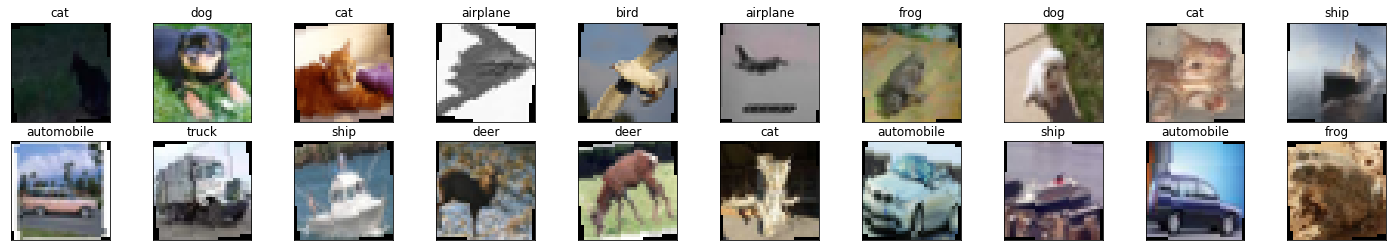

In [6]:
# Visualize a batch of data
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

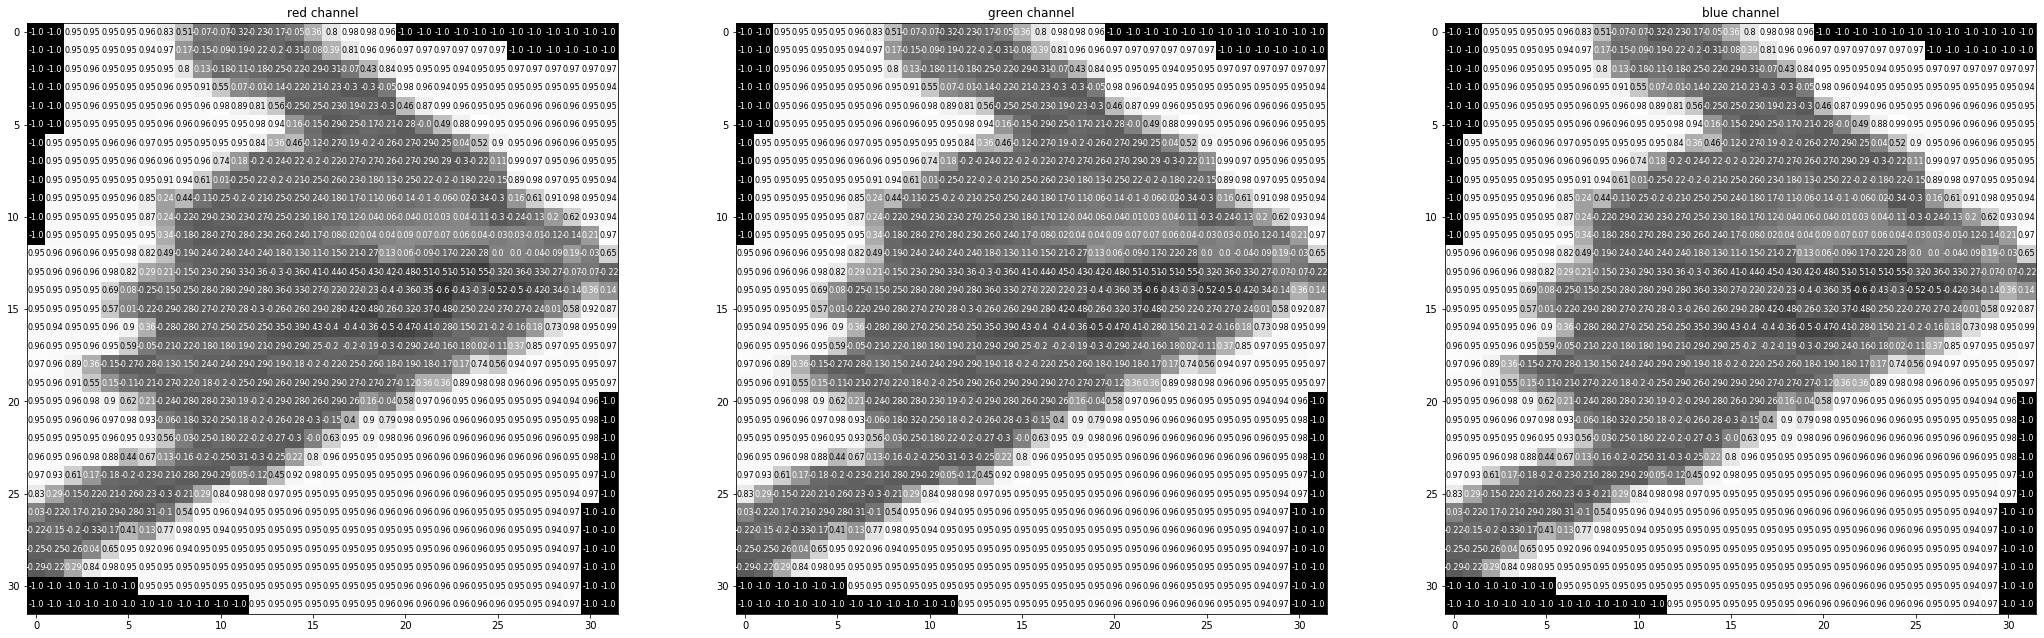

In [11]:
# View an image in more details
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

<h1>Define The Network Architecture</h1>

In [19]:
import torch.nn as nn
import torch.nn.functional as F
#define the CNN architecture

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #flatten the image
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x
model = Network()
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

<h1>Train The Network</h1>

In [21]:
epochs = 30
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    #calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
    

Epoch: 1 	Training Loss: 2.108560 	Validation Loss: 1.800724
Validation loss decreased (inf --> 1.800724).  Saving model ...
Epoch: 2 	Training Loss: 1.687552 	Validation Loss: 1.530360
Validation loss decreased (1.800724 --> 1.530360).  Saving model ...
Epoch: 3 	Training Loss: 1.505623 	Validation Loss: 1.417863
Validation loss decreased (1.530360 --> 1.417863).  Saving model ...
Epoch: 4 	Training Loss: 1.405426 	Validation Loss: 1.301115
Validation loss decreased (1.417863 --> 1.301115).  Saving model ...
Epoch: 5 	Training Loss: 1.312925 	Validation Loss: 1.241542
Validation loss decreased (1.301115 --> 1.241542).  Saving model ...
Epoch: 6 	Training Loss: 1.244105 	Validation Loss: 1.165005
Validation loss decreased (1.241542 --> 1.165005).  Saving model ...
Epoch: 7 	Training Loss: 1.184211 	Validation Loss: 1.105426
Validation loss decreased (1.165005 --> 1.105426).  Saving model ...
Epoch: 8 	Training Loss: 1.133377 	Validation Loss: 1.069772
Validation loss decreased (1.10542

<h1>Test the Trained Network</h1>

In [26]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total= list(0. for i in range(10))

model.eval()

for batch_idx, (data, target) in enumerate(test_loader):
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _,pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.701154

Test Accuracy of airplane: 81% (814/1000)
Test Accuracy of automobile: 89% (893/1000)
Test Accuracy of  bird: 60% (601/1000)
Test Accuracy of   cat: 54% (546/1000)
Test Accuracy of  deer: 75% (756/1000)
Test Accuracy of   dog: 66% (660/1000)
Test Accuracy of  frog: 84% (840/1000)
Test Accuracy of horse: 82% (829/1000)
Test Accuracy of  ship: 83% (831/1000)
Test Accuracy of truck: 83% (838/1000)

Test Accuracy (Overall): 76% (7608/10000)


<h1>Visualize sample test results</h1>

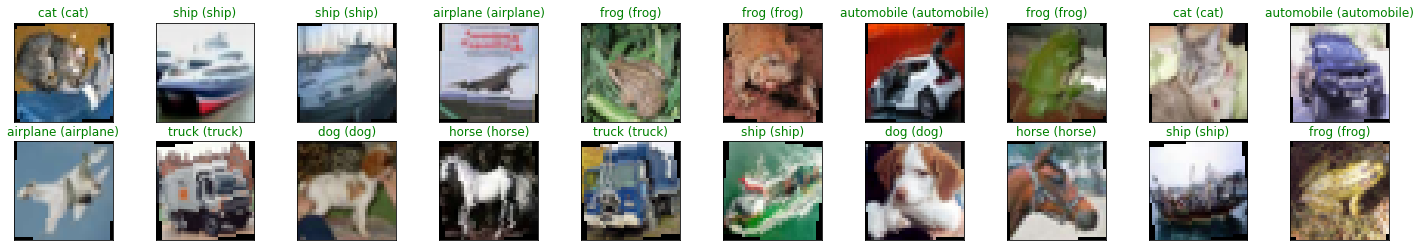

In [27]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))